In [1]:
# imports for data manupulation
import numpy as np
import pandas as pd
import xarray as xr

# import for reading files
from os import listdir
from os.path import isfile, join

In [2]:
# path where the entire data exists
data_path = '/home/mytrah-pc/Data/Mokal/'

# List of all the files
data_files = [f for f in listdir(data_path) if (f[-4:] == '.csv')]

# Sort the files, we need data according to timestamp
data_files = sorted(data_files)

# Get the number of files we are working with
num_data_files = len(data_files)

In [3]:
# Slice the file, for getting the required files
sliced_file_list = data_files[1:146]

In [4]:
# The properties we want to read
properties_list = ['TempBottomControlSection_AVG', 'TempBottomPowerSection_AVG', 'TurbineState_AVG']

# The List of machines we want to study
machine_list = ['MK014', 'MK015', 'MK016', 'MK165']

# machine_num_str = 'MK014MK015MK016MK017MK021MK039MK040MK042MK043MK066MK067MK068MK069' \
#                    + 'MK092MK093MK094MK161MK163MK164MK165'.split('MK')
# machine_list = ['MK' + str(num) for num in machine_num_str[1:]]

# The timestamps where we have the data, convert to real dateTime Objects.
time_stamp_list = pd.to_datetime(
    [file_name[6:21] for file_name in sliced_file_list],
    format = '%Y%m%d-%H%M%S'
)

In [5]:
frame_list = []

for csv_file in sliced_file_list:
    temp_frame = pd.read_csv(join(data_path, csv_file))
    temp_frame.index.name = 'Machine'
    temp_frame.columns.name = 'Properties'
    frame_list.append(temp_frame.set_index('Machine').loc[machine_list][properties_list].as_matrix())

In [6]:
# A 3d Array of the entire data
data_3d_array = np.array(frame_list)

In [7]:
# Creating the Dataset
xr_data = xr.Dataset()

for prop in properties_list:
    xr_data[prop] = (('time_stamp', 'machine'), data_3d_array[:, :, properties_list.index(prop)])

xr_data.coords['time_stamp'] = time_stamp_list
xr_data.coords['machine'] = machine_list

In [8]:
# Column that we want to study
target_column = 'TempBottomControlSection_AVG'

In [9]:
mean_data_array = xr_data[target_column].mean(dim='machine')
std_data_array = xr_data[target_column].std(dim='machine')


# Create a mask for machines with state 9001, Turbine: Error Comm.
mask_turbine_state_is_9001 = xr_data['TurbineState_AVG'].loc[:, machine_list] == 9001

# Removing the data which has 9001 for teh target_column
clean_data = xr_data[target_column].loc[:, machine_list].where(~mask_turbine_state_is_9001,
                                                               drop=True)

In [10]:
# linear Interpolation of NAN values

# Create a mask for values as NAN
mask_nan = np.isnan(clean_data.loc[:, machine_list])

for machine in clean_data.machine:
    clean_data.loc[:, machine][mask_nan.loc[:, machine]] \
    = pd.Series(clean_data.loc[:, machine]).interpolate()[mask_nan.loc[:, machine]]

In [11]:
# mean data of all machines
mean_clean_data = clean_data.mean(dim='machine')

In [12]:
# import for Graphing
import matplotlib.pyplot as plt_obj

# Create a figure and as axes object
fig_obj = plt_obj.figure(figsize = (30, 10))
axes_obj = fig_obj.add_subplot(111)

# A simple Plotter function
def my_plotter(axes_obj, x, y, param_dict):
    out = axes_obj.plot(x, y, **param_dict)
    return out

In [13]:
# This is where all the plotting is done
my_plotter(
    axes_obj,
    mean_clean_data.loc[:].time_stamp,
    mean_clean_data.loc[:],
    {
        'linestyle': '-',
        'marker': '.'
    }
)

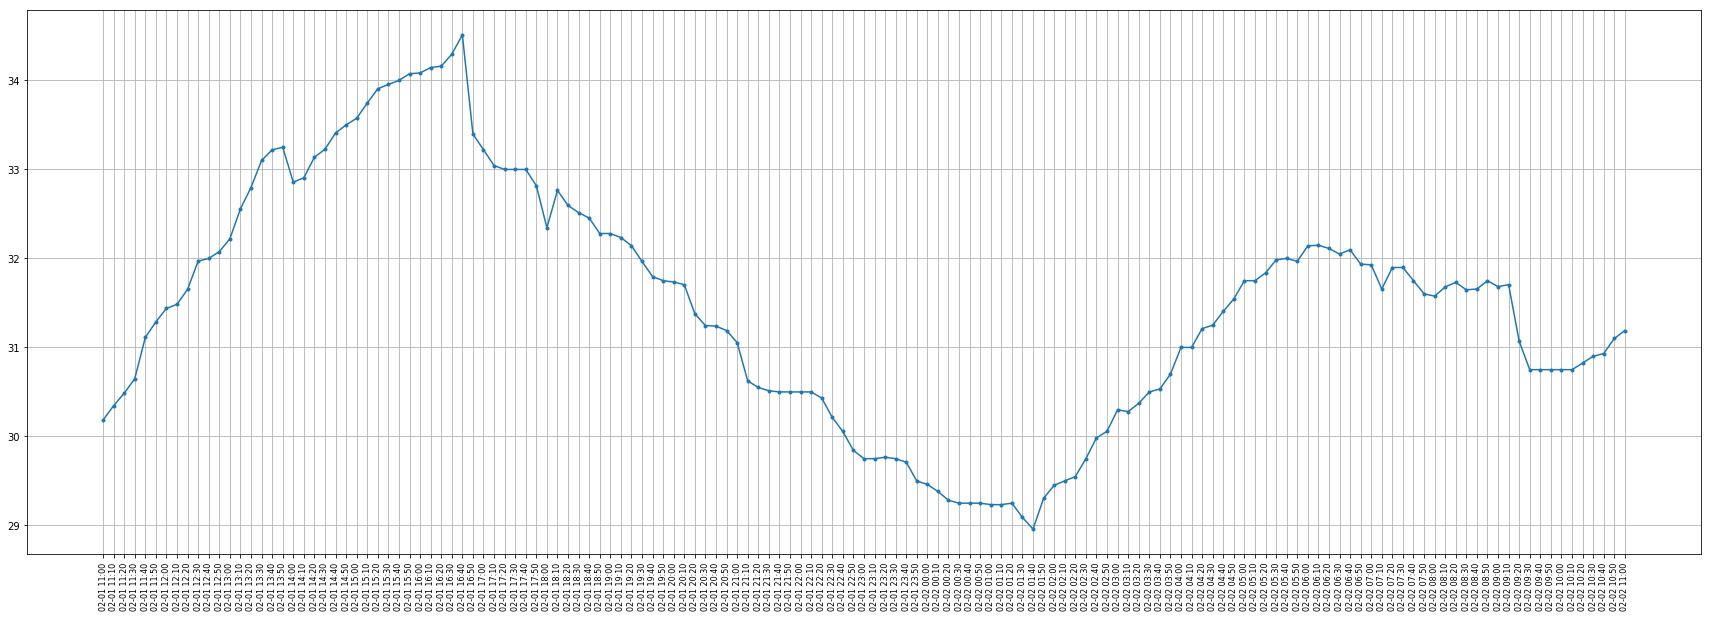

In [14]:

# import for handling dateTime Object
import matplotlib.dates as mdates
#import datetime as dt

# Format how the date should look on the X-axis
axes_obj.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
# Set the number of xticks
axes_obj.set_xticks(pd.date_range(
    time_stamp_list[0],
    #time_stamp_list[-1] + dt.timedelta(minutes=10),
    time_stamp_list[-1],
    freq='10min'
), minor=False)
# Configure for readability
axes_obj.tick_params(
    axis='x',
    which='major',
    pad=5,
    labelsize=8,
    
)
axes_obj.minorticks_on
plt_obj.xticks(rotation=90)
# Display Plot Grid
plt_obj.grid(True)

# Show the Graph (Plot)
plt_obj.show()